# Make classification data and get it ready

In [27]:
#https://scikit-learn.org/stable/datasets/sample_generators.html#sample-generators
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles

from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples,
                    factor=0.7,
                    noise=0.03,
                    random_state=42
                    )
len(X), len(y)

(1000, 1000)

In [28]:
X[:5], y[:5]

(array([[ 0.65770809,  0.20539659],
        [-0.65749029,  0.13699516],
        [-0.71618046,  0.16074871],
        [-0.3511528 ,  0.60240006],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [29]:
import pandas as pd

circles = pd.DataFrame({
    "X1": X[:,0],
    "X2": X[:,1],
    "label": y
})
circles.head(5)

,X1,X2,label
0,0.657708,0.205397,1
1,-0.657490,0.136995,1
2,-0.716180,0.160749,1
3,-0.351153,0.602400,1
4,0.442208,-0.896723,0


In [30]:
circles.label.value_counts()

,count
label,
1,500
0,500


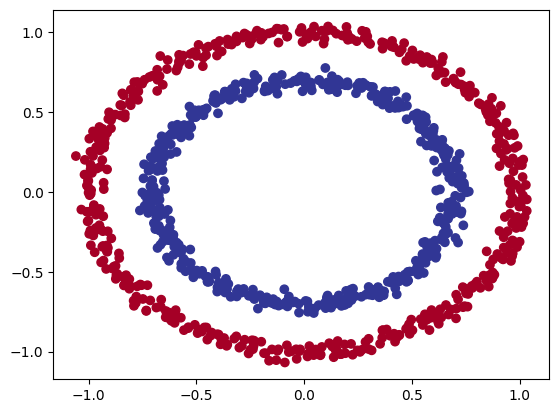

In [31]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu
            )
plt.show()

### Turn data into tensors and create train and test splits

In [32]:
type(X)

numpy.ndarray

In [33]:
import torch

Xt = torch.from_numpy(X).type(torch.float)
yt = torch.from_numpy(y).type(torch.float)
Xt.dtype, yt.dtype

(torch.float32, torch.float32)

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [35]:
X_train[:5], X_test[:5]

(tensor([[ 0.5793, -0.4033],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1454,  0.7017]]),
 tensor([[-0.3259,  0.5956],
         [ 0.0154,  0.9600],
         [-0.6118, -0.2733],
         [-0.2853,  0.9664],
         [ 0.3488, -0.6593]]))

### Buidling a model

In [62]:
from torch import nn

# Make davice agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [37]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # self.two_linear_layers = nn.Sequential(
    #   nn.Linear(in_features=2, out_features=5),
    #   nn.Linear(in_features=5, out_features=1)
    # )

  def forward(self, x):
    return self.layer_2(self.layer_1(x))
    #return self.two_linear_layers(x)

model_0 = CircleModelV0().to(device)
model_0, model_0.state_dict()

(CircleModelV0(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 ),
 OrderedDict([('layer_1.weight',
               tensor([[-0.0309,  0.5170],
                       [ 0.4428,  0.6833],
                       [-0.0729,  0.6095],
                       [ 0.2634,  0.5060],
                       [-0.6483,  0.5325]])),
              ('layer_1.bias',
               tensor([-0.4776, -0.3951,  0.3956,  0.4393, -0.5195])),
              ('layer_2.weight',
               tensor([[ 0.4128,  0.0845,  0.2309, -0.0093, -0.1454]])),
              ('layer_2.bias', tensor([-0.2102]))]))

A [visual example](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.64322&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) of what a similar classification neural network to the one we've just built looks like

In [38]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

### Setup loss function and optimizer

* torch.nn.BCELoss() - Creates a loss function that measures the binary cross entropy between the target (label) and input (features)
* torch.nn.BCEWithLogitsLoss() - This is the same as above except it has a sigmoid layer (nn.Sigmoid) - it's more numerically stable than using torch.nn.BCELoss() after a nn.Sigmoid layer.

In [39]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.1)

In [40]:
### Evaluation metrics

# Accuracy - can be measured by dividing the total number of correct predictions over the total number of predictions.

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

### Going from raw model outputs to predicted labels
* logits -> prediction probabilities -> prediction labels

In [41]:
y_logits = model_0(X_test.to(device))
y_logits[:5]

tensor([[-0.6491],
        [-0.5639],
        [-0.8746],
        [-0.5495],
        [-1.0203]], grad_fn=<SliceBackward0>)

In [42]:
# Use sigmoid on model logits to get predicion probailities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.3432],
        [0.3627],
        [0.2943],
        [0.3660],
        [0.2650]], grad_fn=<SliceBackward0>)

In [43]:
# Turn prediction probabilities into prediction labels
y_preds = torch.round(y_pred_probs)
y_preds[:5]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SliceBackward0>)

In [44]:
# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))
y_test.squeeze()[:10], y_pred_labels.squeeze()[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>))

### Building a training and testing loop

In [45]:
torch.manual_seed(42)
epochs = 100

### Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()
  y_logits = model_0(X_train).squeeze()

  ### Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss
  #                y_train)
  loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss
                 y_train)

  y_pred = torch.round(torch.sigmoid(y_logits))
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ##### Testing
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()

    ### Calculate loss/accuracy
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.77851, Accuracy: 50.00% | Test loss: 0.71613, Test acc: 50.00%
Epoch: 10 | Loss: 0.69391, Accuracy: 38.88% | Test loss: 0.69781, Test acc: 50.00%
Epoch: 20 | Loss: 0.69327, Accuracy: 50.00% | Test loss: 0.69344, Test acc: 47.00%
Epoch: 30 | Loss: 0.69368, Accuracy: 57.25% | Test loss: 0.69728, Test acc: 50.00%
Epoch: 40 | Loss: 0.69318, Accuracy: 43.00% | Test loss: 0.69404, Test acc: 50.00%
Epoch: 50 | Loss: 0.69299, Accuracy: 52.00% | Test loss: 0.69486, Test acc: 48.00%
Epoch: 60 | Loss: 0.69297, Accuracy: 51.38% | Test loss: 0.69522, Test acc: 47.50%
Epoch: 70 | Loss: 0.69296, Accuracy: 50.75% | Test loss: 0.69466, Test acc: 47.00%
Epoch: 80 | Loss: 0.69296, Accuracy: 52.00% | Test loss: 0.69490, Test acc: 45.50%
Epoch: 90 | Loss: 0.69296, Accuracy: 51.12% | Test loss: 0.69495, Test acc: 46.00%


### Make predictions and evaluate the model

In [46]:
# Get helper_functions.py

import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [47]:
from helper_functions import plot_predictions, plot_decision_boundary

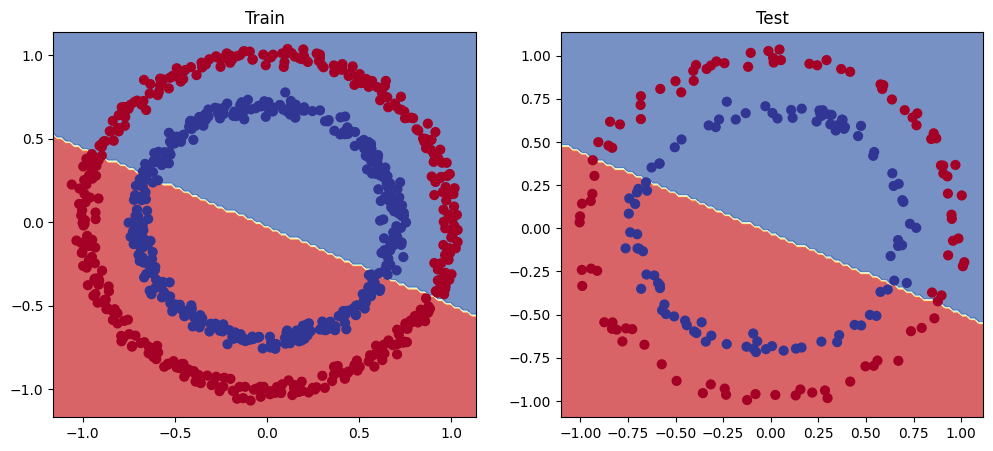

In [48]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### Improving a model (from a model perspective)


In [49]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    #z = self.layer_1(x)
    #z = self.layer_2(z)
    #z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [50]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.1)

In [51]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    loss_test = loss_fn(test_pred, y_test)
    acc_test = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69390, Accuracy: 51.75% | Test loss: 0.69483, Test acc: 45.50%
Epoch: 100 | Loss: 0.69296, Accuracy: 51.25% | Test loss: 0.69483, Test acc: 45.50%
Epoch: 200 | Loss: 0.69296, Accuracy: 51.50% | Test loss: 0.69483, Test acc: 45.50%
Epoch: 300 | Loss: 0.69296, Accuracy: 51.50% | Test loss: 0.69483, Test acc: 45.50%
Epoch: 400 | Loss: 0.69296, Accuracy: 51.50% | Test loss: 0.69483, Test acc: 45.50%
Epoch: 500 | Loss: 0.69296, Accuracy: 51.50% | Test loss: 0.69483, Test acc: 45.50%
Epoch: 600 | Loss: 0.69296, Accuracy: 51.50% | Test loss: 0.69483, Test acc: 45.50%
Epoch: 700 | Loss: 0.69296, Accuracy: 51.50% | Test loss: 0.69483, Test acc: 45.50%
Epoch: 800 | Loss: 0.69296, Accuracy: 51.50% | Test loss: 0.69483, Test acc: 45.50%
Epoch: 900 | Loss: 0.69296, Accuracy: 51.50% | Test loss: 0.69483, Test acc: 45.50%


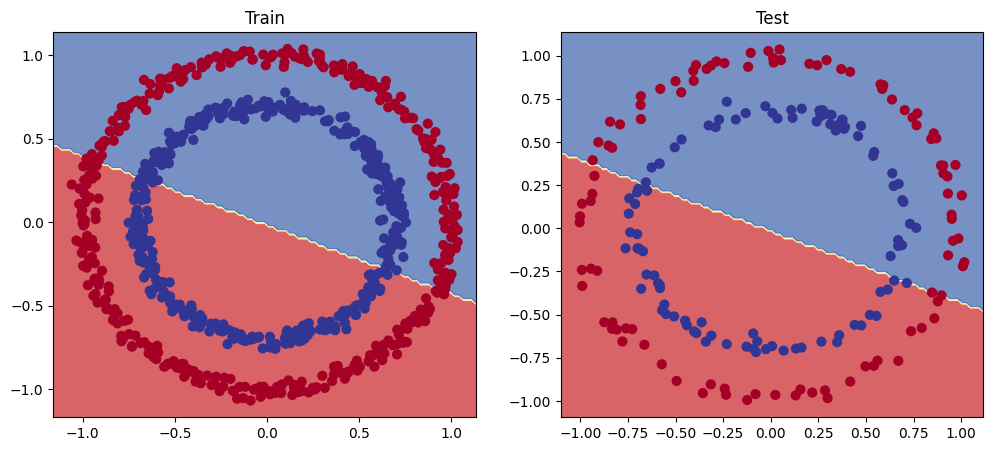

In [52]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

###The missing piece: non-linearity

In [53]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [54]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_2.parameters())

In [55]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  ### Training
  model_2.train()
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ###Testing
  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69303, Accuracy: 50.00% | Test Loss: 0.69311, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.67955, Accuracy: 58.38% | Test Loss: 0.67807, Test Accuracy: 62.00%
Epoch: 200 | Loss: 0.64397, Accuracy: 72.00% | Test Loss: 0.63851, Test Accuracy: 76.50%
Epoch: 300 | Loss: 0.56554, Accuracy: 85.62% | Test Loss: 0.55702, Test Accuracy: 89.00%
Epoch: 400 | Loss: 0.41900, Accuracy: 93.62% | Test Loss: 0.41857, Test Accuracy: 94.00%
Epoch: 500 | Loss: 0.27779, Accuracy: 99.50% | Test Loss: 0.28658, Test Accuracy: 100.00%
Epoch: 600 | Loss: 0.17642, Accuracy: 100.00% | Test Loss: 0.18741, Test Accuracy: 100.00%
Epoch: 700 | Loss: 0.11310, Accuracy: 100.00% | Test Loss: 0.12502, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.07710, Accuracy: 100.00% | Test Loss: 0.08899, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.05565, Accuracy: 100.00% | Test Loss: 0.06677, Test Accuracy: 100.00%


###Evaluating a model trained with non-linear activation functions

In [56]:
# Make predictions
model_2.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

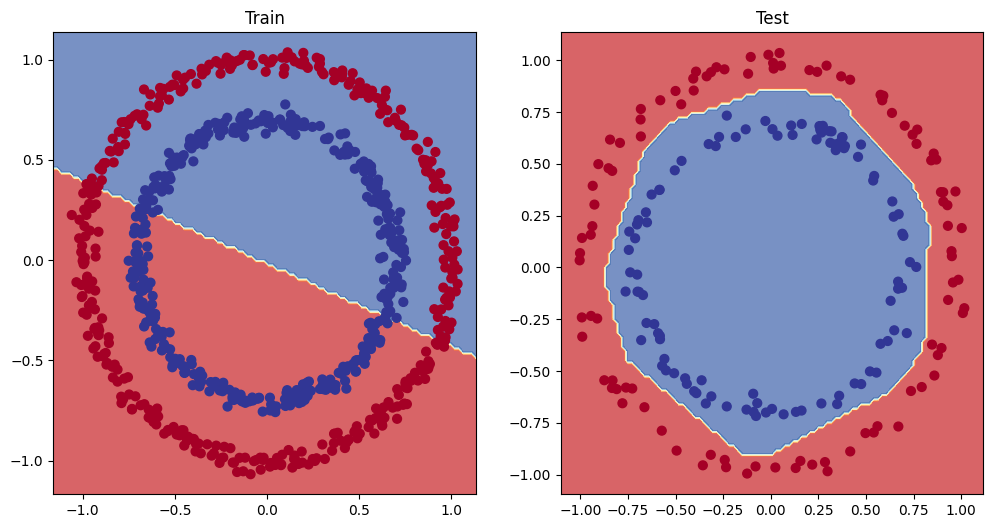

In [57]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test) # model_2 = has non-linearity

# Multiclass Classification
#### Make Blobs
* https://scikit-learn.org/stable/datasets/sample_generators.html#sample-generators
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs

In [92]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state= RANDOM_SEED)

X_blob_train[:5], y_blob_train[:5]

(tensor([[ 5.0405,  3.3076],
         [-2.6249,  9.5260],
         [-8.5240, -9.0402],
         [-6.0262, -4.4375],
         [-3.3397,  7.2175]]),
 tensor([1., 0., 2., 2., 0.]))

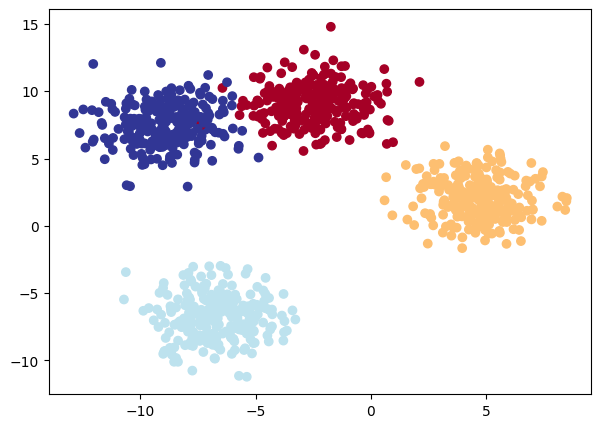

In [93]:
plt.figure(figsize=(7,5))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [94]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [95]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
      return self.linear_layer_stack(x)

model_3 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [96]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.1)

### Getting prediction probabilities for a multi-class PyTorch model

In [97]:
model_3.eval()
with torch.inference_mode():
  y_logits=model_3(X_blob_train.to(device))
y_logits[:5], y_train[:5]

(tensor([[ 0.6226, -0.4992,  0.3042, -0.2222],
         [ 0.6736, -1.1873,  0.1842, -0.6871],
         [ 0.2130, -0.9997,  0.3891, -1.0923],
         [ 0.4027, -0.7745,  0.4512, -0.8176],
         [ 0.3791, -1.2052,  0.0704, -0.7173]]),
 tensor([1., 0., 0., 0., 1.]))

In [98]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[0.4028, 0.1312, 0.2930, 0.1731],
        [0.4938, 0.0768, 0.3027, 0.1267],
        [0.3622, 0.1077, 0.4319, 0.0982],
        [0.3770, 0.1161, 0.3957, 0.1113],
        [0.4398, 0.0902, 0.3230, 0.1469]])

In [99]:
sum(y_pred_probs[0])

tensor(1.)

In [100]:
y_pred = torch.argmax(y_pred_probs[0])
y_pred

tensor(0)

Note: To summarize the above, a model's raw output is referred to as logits.

For a multi-class classification problem, to turn the logits into prediction probabilities, you use the softmax activation function (torch.softmax).

The index of the value with the highest prediction probability is the class number the model thinks is most likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

In [104]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.type(torch.LongTensor).to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.type(torch.LongTensor).to(device)

for epoch in range(epochs):
  ### Training
  model_3.train()
  y_logits = model_3(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

  if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.01535, Acc: 99.50% | Test Loss: 0.00461, Test Acc: 100.00%
Epoch: 10 | Loss: 0.01513, Acc: 99.38% | Test Loss: 0.00423, Test Acc: 100.00%
Epoch: 20 | Loss: 0.01492, Acc: 99.38% | Test Loss: 0.00386, Test Acc: 100.00%
Epoch: 30 | Loss: 0.01471, Acc: 99.38% | Test Loss: 0.00377, Test Acc: 100.00%
Epoch: 40 | Loss: 0.01440, Acc: 99.38% | Test Loss: 0.00363, Test Acc: 100.00%
Epoch: 50 | Loss: 0.01421, Acc: 99.38% | Test Loss: 0.00334, Test Acc: 100.00%
Epoch: 60 | Loss: 0.01387, Acc: 99.38% | Test Loss: 0.00383, Test Acc: 100.00%
Epoch: 70 | Loss: 0.01389, Acc: 99.38% | Test Loss: 0.00298, Test Acc: 100.00%
Epoch: 80 | Loss: 0.01382, Acc: 99.38% | Test Loss: 0.00317, Test Acc: 100.00%
Epoch: 90 | Loss: 0.01315, Acc: 99.38% | Test Loss: 0.00329, Test Acc: 100.00%


In [105]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

y_pred[:10]

tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0])

In [107]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

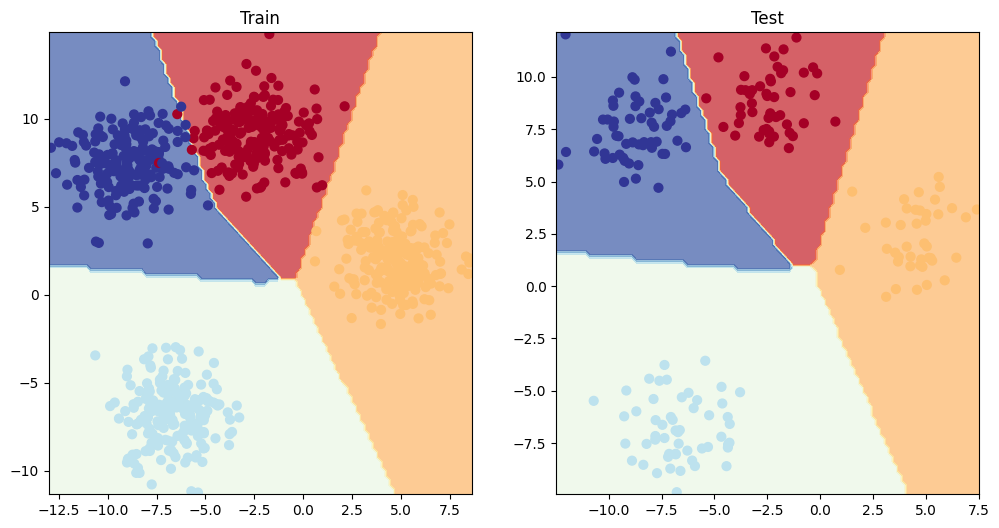

In [108]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_blob_test, y_blob_test)